#Code for ViViT model [[paper]](https://arxiv.org/abs/2103.15691)


## Imports and Global declarations

In [1]:
# Imports

import torch
from torch import nn, einsum
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision as tv
from torch.utils.data import random_split, DataLoader,Dataset

import os
import time
import random
import math

# !pip install einops icecream
import decord
import numpy as np
import gc
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from PIL import Image
from tqdm.notebook import tqdm
from icecream import ic
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set device
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# Instantiate tensorboard writer
tb_writer = SummaryWriter()

## DataLoader for UCF101 dataset 

In [3]:
# dataset params
frames_per_clip = 8
dataset_dir="./ucf/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"
video_dir = "./ucf/UCF101/UCF-101"

In [4]:
# Dataset Class
class UCFDataset(torch.utils.data.Dataset):
    """
    Dataset Class for reading UCF101 dataset  
    
    Args:
        dataset_dir: (str) - root directory of dataset
        subset: (str) - train or test subset
        video_list_file: (str) - file name containing list of video names 
        frames_per_clip: (int) - number of frames to be read in every video clip [default:16]
    """

    def __init__(self, dataset_dir, subset, video_list_file, frames_per_clip=16):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.video_dir = video_dir
        self.subset=subset
        self.video_list_file = video_list_file
        self.video_list = []
        self.labels = []
        self.indices = []

        for i in [1,2,3]:
            with open(f'{dataset_dir}/{video_list_file}{str(i)}.txt') as video_names_file:
                if self.subset=="train":
                    tempvideo_list,templabels = zip(*(files[:-1].split() for files in video_names_file.readlines()))
                    self.video_list += tempvideo_list
                    self.labels += templabels
                else:
                    tempvideo_list = [files[:-1] for files in video_names_file.readlines()]
                    templabels = [None]
                    self.video_list += tempvideo_list
                    self.labels += templabels
                    # with open(f'{dataset_dir}/classInd.txt') as classIndices:
                    #     values,keys=zip(*(files[:-1].split() for files in classIndices.readlines()))
                    #     tempindices = dict( (k,v) for k,v in zip(keys,values))
                    
            
            #self.indices.append(tempindices)
        

        self.frames_per_clip = frames_per_clip

        self.transform = tv.transforms.Compose([
          tv.transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
          tv.transforms.Resize(256,interpolation=tv.transforms.InterpolationMode.BICUBIC),
          tv.transforms.CenterCrop(224),
          tv.transforms.ToTensor(),
          tv.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        videoname = f'{self.video_list[idx]}'
        vid = decord.VideoReader(f'{self.video_dir}/{videoname}', ctx=decord.cpu(0))
        nframes = len(vid)

        # if number of frames of video is less than frames_per_clip, repeat the frames
        if nframes <= self.frames_per_clip:
            idxs = np.arange(0, self.frames_per_clip).astype(np.int32)
            idxs[nframes:] %= nframes

        # else if frames_per_clip is greater, sample uniformly seperated frames
        else:
            idxs = np.linspace(0, nframes-1, self.frames_per_clip)
            idxs = np.round(idxs).astype(np.int32)

        imgs = []
        for k in idxs:
            frame = Image.fromarray(vid[k].asnumpy())
            frame = self.transform(frame)
            imgs.append(frame)
        imgs = torch.stack(imgs)

        # if its train subset, return both the frames and the label 
        if self.subset=="train":
            label = int(self.labels[idx]) - 1    
        # else, for test subset, read the label index
        else:
            with open(f'{dataset_dir}/classInd.txt') as classIndices:
                label=int(classIndices[videoname.split('/')[0]])
        return imgs,label

In [5]:
#Instantiate and create train-val-test split

train_val_data = UCFDataset( dataset_dir = dataset_dir, subset="train", video_list_file="trainlist0",frames_per_clip=frames_per_clip)

train_len=int(0.85*len(train_val_data))
train_val_split = [ train_len, len(train_val_data) - train_len ] 

train_data , val_data = random_split(train_val_data,train_val_split)
test_data = UCFDataset( dataset_dir = dataset_dir, subset="test", video_list_file="testlist0" ,frames_per_clip=frames_per_clip)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Train samples: 24434
Validation samples: 4313
Test samples: 11213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])
19


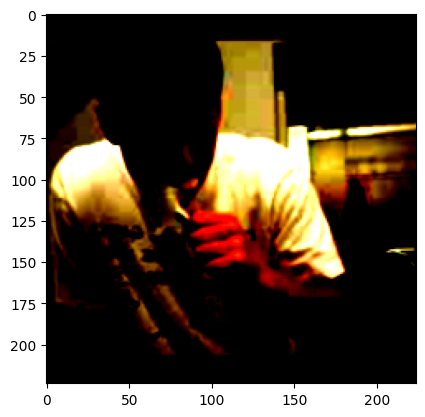

In [7]:
#example frame from a random video to check if dataloader's working properly
plt.imshow(((train_data[35][0][0].permute(1,2,0)*255).int()).numpy())
print(train_data[35][0].shape)  #Size([8, 3, 224, 224])
print(train_data[35][1])        # label

In [6]:
# data loading params
batch_size = 256
test_batch_size = 1
num_workers = 8
pin_memory = True
num_classes=101

In [7]:
# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=test_batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size)

## Model definition

In [8]:
class MLP(nn.Module):
    """
    Builds a simple feed forward network
    
    Args:
        dim: (int) - inner dimension of| embeddings 
        inner_dim: (int) - dimension of transformer head  
    
    """

    def __init__(self, dim, inner_dim,n_class,encoder):     #dim would be the output image feature from dinov2
                                                        
        super().__init__()
        # mlp with GELU activation function
        self.encoder = encoder
        self.mlp = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU(),
            nn.Dropout(0.5),
            #nn.Linear(inner_dim, inner_dim),
            #nn.GELU(),
            nn.Linear(inner_dim, n_class),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        # x is [16,8,3,224,224]
        avg = []
        
        for i in range(8):
            xi = x[:,i,:]
            
            #encode x to [8,384]
            e = []
            with torch.no_grad():
                # features_dict = self.encoder.forward_features(xi)
                # e = features_dict['x_norm_patchtokens']
                e = self.encoder(xi).reshape(x.shape[0],1,384)
            avg.append(e)
        avg = torch.cat(avg,dim=1)    
        
               
        avg = reduce(avg, "f t c -> f c",'mean')        #[16,384]
        
        return self.mlp(avg)

In [ ]:
# class Attention(nn.Module):
#     """
#     Builds a Self Attention Module, however, could be modified to make other attention modules too.
    
#     Args:
#         dim: (int) - inner dimension of embeddings[default:192] 
#         heads: (int) - number of attention heads[default:8] 
#         dim_head: (int) - dimension of transformer head [default:64] 
    
#     """

#     def __init__(self, dim = 192, heads = 8, dim_head = 64):
#         super().__init__()
#         inner_dim = dim_head *  heads

#         self.heads = heads
#         self.scale = dim_head ** -0.5

#         # nn.Linear from 192 to (8*64)*3
#         self.make_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

#         # Linear projection to required output dimension
#         self.get_output = nn.Sequential(nn.Linear(inner_dim, dim))
        

#     def forward(self, x):

#         b, n, _ = x.shape   # b=batch_size , n=197 
#         h = self.heads      # h=8

#         # nn.Linear from 192 to 256*3 & then split it across q,k & v each with last dimension as 256
#         qkv = self.make_qkv(x).chunk(3, dim = -1)
        
#         # reshaping to get the right q,k,v dimensions having 8 attn_heads(h)
#         q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

#         # dot product of q & k after transposing k followed by a softmax layer
#         dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale     # q.kT / sqrt(d)
#         attn = dots.softmax(dim=-1)

#         # dot product of attention layer with v
#         output = einsum('b h i j, b h j d -> b h i d', attn, v)

#         # Final reshaping & nn.Linear to combine all attention head outputs to get final out.
#         output = rearrange(output, 'b h n d -> b n (h d)')
        
#         output =  self.get_output(output)    
#         # output shape = ( b, n, dim (=192) )

#         return output  

In [ ]:
# class Transformer(nn.Module):
#     """
#     Builds a Transformer Model. Could be used as a Spatial or Temporal transformer.
    
#     Args:
#         dim: (int) - inner dimension of embeddings 
#         depth: (int) - depth of the transformer 
#         heads: (int) - number of attention heads [default:8] 
#         dim_head: (int) - dimension of transformer head [default:64] 
#         mlp_dim: (int) - scaling dimension for attention [default:768] 
    
#     """

#     def __init__(self, dim, depth, heads=8, dim_head=64, mlp_dim=768):
#         super().__init__()
        
#         self.model_layers = nn.ModuleList([])
#         for i in range(depth):
#             self.model_layers.append(nn.ModuleList([
#                 nn.LayerNorm(dim),
#                 Attention(dim, heads, dim_head),
#                 nn.LayerNorm(dim),
#                 MLP(dim, mlp_dim)
#             ]))

#         self.layer_norm = nn.LayerNorm(dim)
    
#     def forward(self, x):

#         for layer_norm1, attention, layer_norm2, ff_net in self.model_layers:
#             x = attention(layer_norm1(x)) + x
#             x = ff_net(layer_norm2(x)) + x

#         return self.layer_norm(x)

Referred from [this](https://github.com/rishikksh20/ViViT-pytorc) unofficial implementation


In [ ]:
# class ViViT(nn.Module):
#     """
#     Builds a ViViT Model for video action recognition
#     The line-by-line comments are for default values of arguments  
    
#     Args:
#         image_size: (int) - size of input image
#         patch_size: (int) - size of each patch of the image 
#         num_classes: (int) - number of classes in the dataset
#         frames_per_clip: (int) - number of frames in every video clip. [default:16] 
#         dim: (int) - inner dimension of embeddings[default:192] 
#         depth: (int) - depth of the transformer[default:4] 
#         heads: (int) - number of attention heads for the transformer[default:8] 
#         pooling: (str) - type of pooling[default:'mean'] 
#         in_channels: (int) - number of input channels for each frame [default:3] 
#         dim_head: (int) - dimension of transformer head [default:64] 
#         scale_dim: (int) - scaling dimension for attention [default:4] 
    
#     """

#     def __init__(self, image_size, patch_size, num_classes, frames_per_clip=16, dim = 192, depth = 4, heads = 8, pooling = 'mean', in_channels = 3, dim_head = 64, scale_dim = 4, ):
        
#         super().__init__()

#         num_patches = (image_size // patch_size) ** 2   # => 196 for 224x224 images
#         patch_dim = in_channels * patch_size ** 2      # => 3*16*16

#         self.get_patch_emb = nn.Sequential(
#             # input h = 14, w=14, c=3, p1=16, p2=16
#             # reshape from (batch_size, frames, channels, 224, 224) to  (batch_size, frames, 14*14, 16*16*3 )
#             Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),  

#             # fully connected from 16*16*3 to 192 for every patch in (batch_size, frames) 
#             nn.Linear(patch_dim, dim),
#         )

#         # position embeddings of shape: (1, frames_per_clip = 16, num_patches + 1 = 197, 192)
#         self.pos_embedding = nn.Parameter(torch.randn(1, frames_per_clip, num_patches + 1, dim))

#         # space (i.e. for each image) tokens of shape: (1, 1, 192). The 192 is the tokens obtained in "get_patch_emb" 
#         self.spatial_token = nn.Parameter(torch.randn(1, 1, dim))
        
#         # spatial transformer ViT
#         self.spatial_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim)

#         # time dimention tokens of shape: (1, 1, 192). 
#         self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        
#         # temporal transformer which takes in spacetransformer's output tokens as the input. 
#         self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim)

#         # pooling type, could be "mean" or "cls"
#         self.pooling = pooling

#         # mlp head for final classification
#         self.classifier_head = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, num_classes),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):

#         # get patch embeddings
#         x = self.get_patch_emb(x)

#         # b = batch_size , t = frames , n = number of patch embeddings= 14*14 , e = embedding size
#         b, t, n, e = x.shape     # x.shape = (b, t, 196, 192) 

#         # prepare cls_token for space transformers
#         spatial_cls_tokens = repeat(self.spatial_token, '() n d -> b t n d', b = b, t=t)

#         # concatenate cls_token to the patch embedding
#         x = torch.cat((spatial_cls_tokens, x), dim=2)     # => x shape = ( b, t, 197 ,192)

#         # add position embedding info 
#         x += self.pos_embedding[:, :, :(n + 1)]

#         # club together the b & t dimension 
#         x = rearrange(x, 'b t n d -> (b t) n d')

#         # pass through spatial transformer
#         x = self.spatial_transformer(x)

#         # declub b & t dimensions
#         x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

#         # prepare cls_token for temporal transformers & concatenate cls_token to the patch embedding
#         temporal_cls_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
#         x = torch.cat((temporal_cls_tokens, x), dim=1)

#         # pass through spatial transformer
#         x = self.temporal_transformer(x)
        
#         # if pooling is mean, then use mean of all 197 as the output, else use output corresponding to cls token as the final x
#         if self.pooling == 'mean':
#             x = x.mean(dim = 1) #( b, n, dim (=192) )
#         else:
#              x[:, 0] #( b, n, dim (=192) )

#         # pass through MLP classification layer
#         return self.classifier_head(x)

In [9]:
# instantiate model and plot on tensorboard
#model = ViViT(image_size=224, patch_size=16, num_classes=num_classes, frames_per_clip=frames_per_clip)
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.to(device)
for param in dinov2_vits14.parameters():
    param.requires_grad= False
model = MLP(384,512,101,dinov2_vits14)
#frames, _ = next(iter(train_loader))
#tb_writer.add_graph(model, frames)
model.to(device)

Using cache found in /home/z3qian/.cache/torch/hub/facebookresearch_dinov2_main


MLP(
  (encoder): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (

## Training utils 

In [10]:
# training hyper-params
lr=0.001
epochs = 20 

In [11]:
# define the loss and optimizers
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=0,lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1_000_00, eta_min=0)
#optimizer = torch.optim.Adam(model.parameters(),lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


In [12]:
# training step for every epoch
def train_step(loader,epoch,):
    
    model.train()
    total_epoch_loss=0
    
    for batch_id, (video_data,labels) in enumerate(loader):

        # video_data,labels = video_data.to(device), labels.to(device)
        video_data,labels = video_data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        prediction = model(video_data)

        loss = loss_criterion(prediction,labels)
        total_epoch_loss += loss.item()

        loss.backward()
        
        optimizer.step()

        del video_data
        del labels

        gc.collect()
        
        #tb_writer.add_scalar("Train/Loss",loss.item(),((len(loader))*(epoch-1))+batch_id)
 
        print(f"\n[Train Epoch]: {epoch} Train Loss: {loss.item()}")

    return total_epoch_loss

In [13]:
# validation step for every epoch
def val_step(loader,epoch=None):

    model.eval()
    total_loss=0
    corrects=0
    
    with torch.no_grad():
        for batch_id, (video_data,labels) in enumerate(loader):

            video_data,labels = (video_data).to(device), labels.to(device)

            prediction = model(video_data)
            
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*batch_size)
    
    print(f"\n[Val Epoch]: {epoch} , Accuracy: {accuracy}, Valid Loss: {loss.item()}")
    #tb_writer.add_scalar("Validation/Loss",loss.item(),epoch)
    #tb_writer.add_scalar("Validation/Accuracy",accuracy,epoch)

    return accuracy

## Train Loop

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

mlp.0.weight
mlp.0.bias
mlp.3.weight
mlp.3.bias


In [15]:
# Driving train test loop
for epoch in tqdm(range(1,epochs+1)):
    train_step(train_loader, epoch)
    val_step(val_loader, epoch)
    scheduler.step()
    torch.save(model,"dino_model.pt")

  0%|          | 0/20 [00:00<?, ?it/s]


[Train Epoch]: 1 Train Loss: 5.104419231414795

[Train Epoch]: 1 Train Loss: 5.1691412925720215

[Train Epoch]: 1 Train Loss: 5.155609130859375

[Train Epoch]: 1 Train Loss: 5.087813854217529

[Train Epoch]: 1 Train Loss: 5.252981185913086

[Train Epoch]: 1 Train Loss: 5.1977152824401855

[Train Epoch]: 1 Train Loss: 5.086484909057617

[Train Epoch]: 1 Train Loss: 5.0551228523254395

[Train Epoch]: 1 Train Loss: 5.063329219818115

[Train Epoch]: 1 Train Loss: 4.995556831359863

[Train Epoch]: 1 Train Loss: 5.00075626373291

[Train Epoch]: 1 Train Loss: 4.951140403747559

[Train Epoch]: 1 Train Loss: 4.98268985748291

[Train Epoch]: 1 Train Loss: 4.978192329406738

[Train Epoch]: 1 Train Loss: 4.858349800109863

[Train Epoch]: 1 Train Loss: 4.840404510498047

[Train Epoch]: 1 Train Loss: 4.850349426269531

[Train Epoch]: 1 Train Loss: 4.788262844085693

[Train Epoch]: 1 Train Loss: 4.859483242034912

[Train Epoch]: 1 Train Loss: 4.806493759155273

[Train Epoch]: 1 Train Loss: 4.8465390

## Testing

In [ ]:
# test the trained model  
def test_model(loader):

    model.eval()
    corrects=0
    
    with torch.no_grad():
        for batch_id, (input_data,labels) in enumerate(loader):

            input_data = (input_data).to(device), labels.to(device)

            prediction = model(input_data)
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*batch_size)
    print(f"Test Accuracy: {accuracy}, Test Loss: {loss.item()}")

    return accuracy

In [ ]:
test_model(model, test_loader)

## Visualize results on tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs/ 